# 6° Desafio de Dados de Moedas Digitais

Risco DeFi-Nativo" (Aave) com o "Risco TradFi-Tokenizado" (OUSG da Ondo Finance)

O Aave é um dos maiores e mais antigos protocolos de lending (empréstimo) descentralizados. Ele não lida com "crédito privado" (empréstimos para empresas), mas sim com empréstimos sobrecolateralizados (usuários depositam, ex: ETH, para pegar emprestado USDC). O seu "ativo de risco" seria o yield pago para quem deposita USDC na plataforma.

Secured Overnight Financing Rate. Esta é, na prática, a taxa de juros "livre de risco" de um dia para o outro (overnight) lastreada em Títulos do Tesouro. É o "bloco de construção" fundamental do OUSG. O APY do OUSG é, essencialmente, SOFR - taxas

Estamos querendo modelar o spread de juros de rendimento de ambos os ativos. Isto é

$$ Y = APY{Aave} - SOFR $$

Tese: O spread de juros​ não é aleatório. Ele é um "termômetro de risco" do sistema DeFi, e podemos modelar seus principais vetores (drivers) on-chain e off-chain.

(melhorar)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Merging the data

Após chamar o script `merging_data.py` temos, enfim, o nosso dataset.

In [2]:
df = pd.read_csv("../data/dataset.csv")
df.head()

,date,Y1_Aave_APY,X_Aave_Utilization,X_USDC_Depeg_Risk,Y2_Ondo_Proxy_APY,X_VIX,X_DGS2,X_BTC_Price,X_ETH_Price,UnixTimeStamp,Value (Wei),X_Gas_Price_Gwei,Y_Target_Spread,X_ETH_Vol_7D,X_Gas_MA_7D,X_VIX_Pct_Change_1D,X_Aave_Util_Accel_1D
0,2025-08-21,4.608218,0.851342,0.000137,4.34996,16.60,3.79,116908.68,4831.24,1.755734e+09,1.768708e+09,1.768708,0.258258,0.182410,1.606519,0.057999,0.005166
1,2025-08-22,4.658812,0.855968,0.000102,4.35065,14.22,3.68,115383.87,4776.73,1.755821e+09,3.463429e+09,3.463429,0.308162,0.183398,1.825379,-0.143373,0.004625
2,2025-08-23,4.734368,0.862894,0.000010,4.35065,14.22,3.68,113478.00,4779.87,1.755907e+09,1.313758e+09,1.313758,0.383718,0.183818,1.845114,0.000000,0.006926
3,2025-08-24,4.632112,0.853536,0.000106,4.35065,14.22,3.68,110127.74,4377.02,1.755994e+09,1.540974e+09,1.540974,0.281462,0.203671,1.890546,0.000000,-0.009358
4,2025-08-25,4.759837,0.865199,0.000180,4.35402,14.79,3.73,111788.01,4601.64,1.756080e+09,1.715434e+09,1.715434,0.405817,0.194793,1.913269,0.040084,0.011663


In [3]:
df = pd.read_csv('../data/dataset.csv')
df['X_Spread_Lag1'] = df['Y_Target_Spread'].shift(1)
df = df.dropna(subset=['X_Spread_Lag1']).reset_index(drop=True)


[]

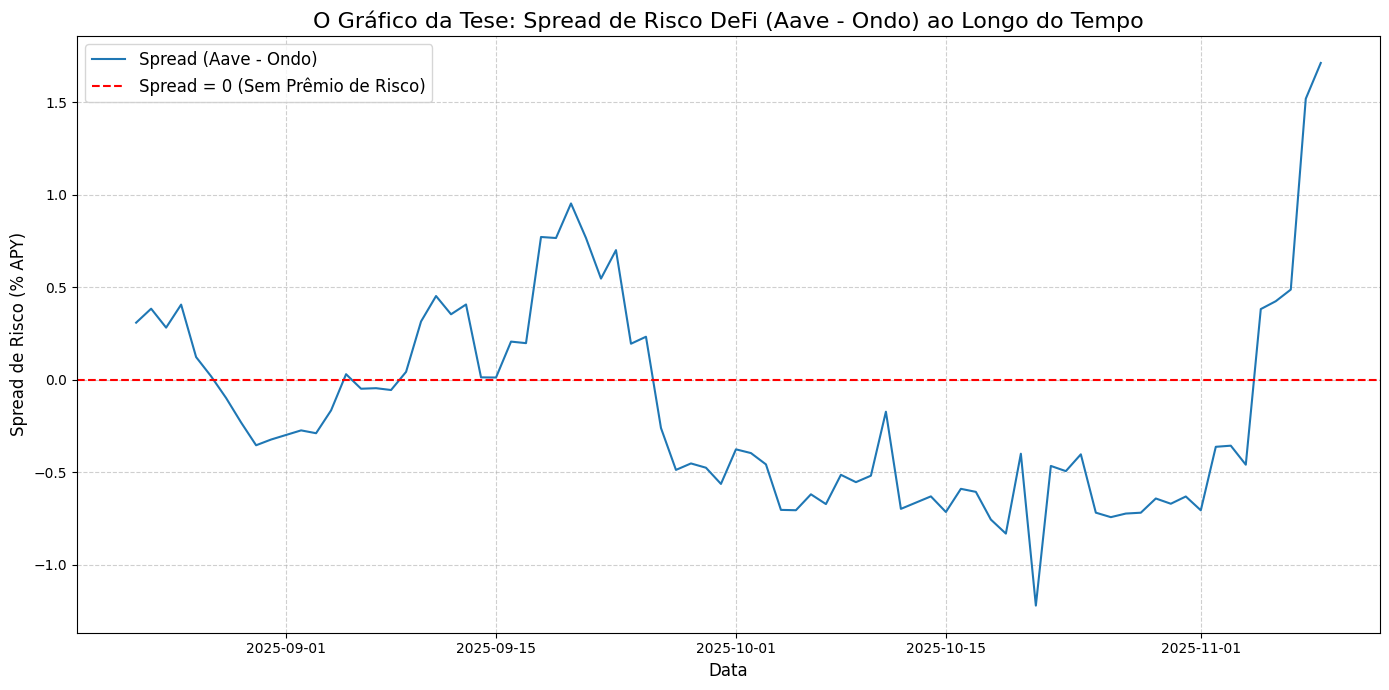

In [4]:
# --- 2. Preparar os Dados ---
# Converter a coluna 'date' de string para datetime e defini-la como índice
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# --- 3. Gerar "O Gráfico da Tese" (Plot de Série Temporal) ---
plt.figure(figsize=(14, 7))
ax = sns.lineplot(x=df.index, y=df['Y_Target_Spread'], label='Spread (Aave - Ondo)')

# Adicionar uma linha de base em 0
ax.axhline(0, ls='--', color='red', lw=1.5, label='Spread = 0 (Sem Prêmio de Risco)')

# Melhorar a formatação
plt.title('O Gráfico da Tese: Spread de Risco DeFi (Aave - Ondo) ao Longo do Tempo', fontsize=16)
plt.ylabel('Spread de Risco (% APY)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Plotar o gráfico
plt.plot()

[]

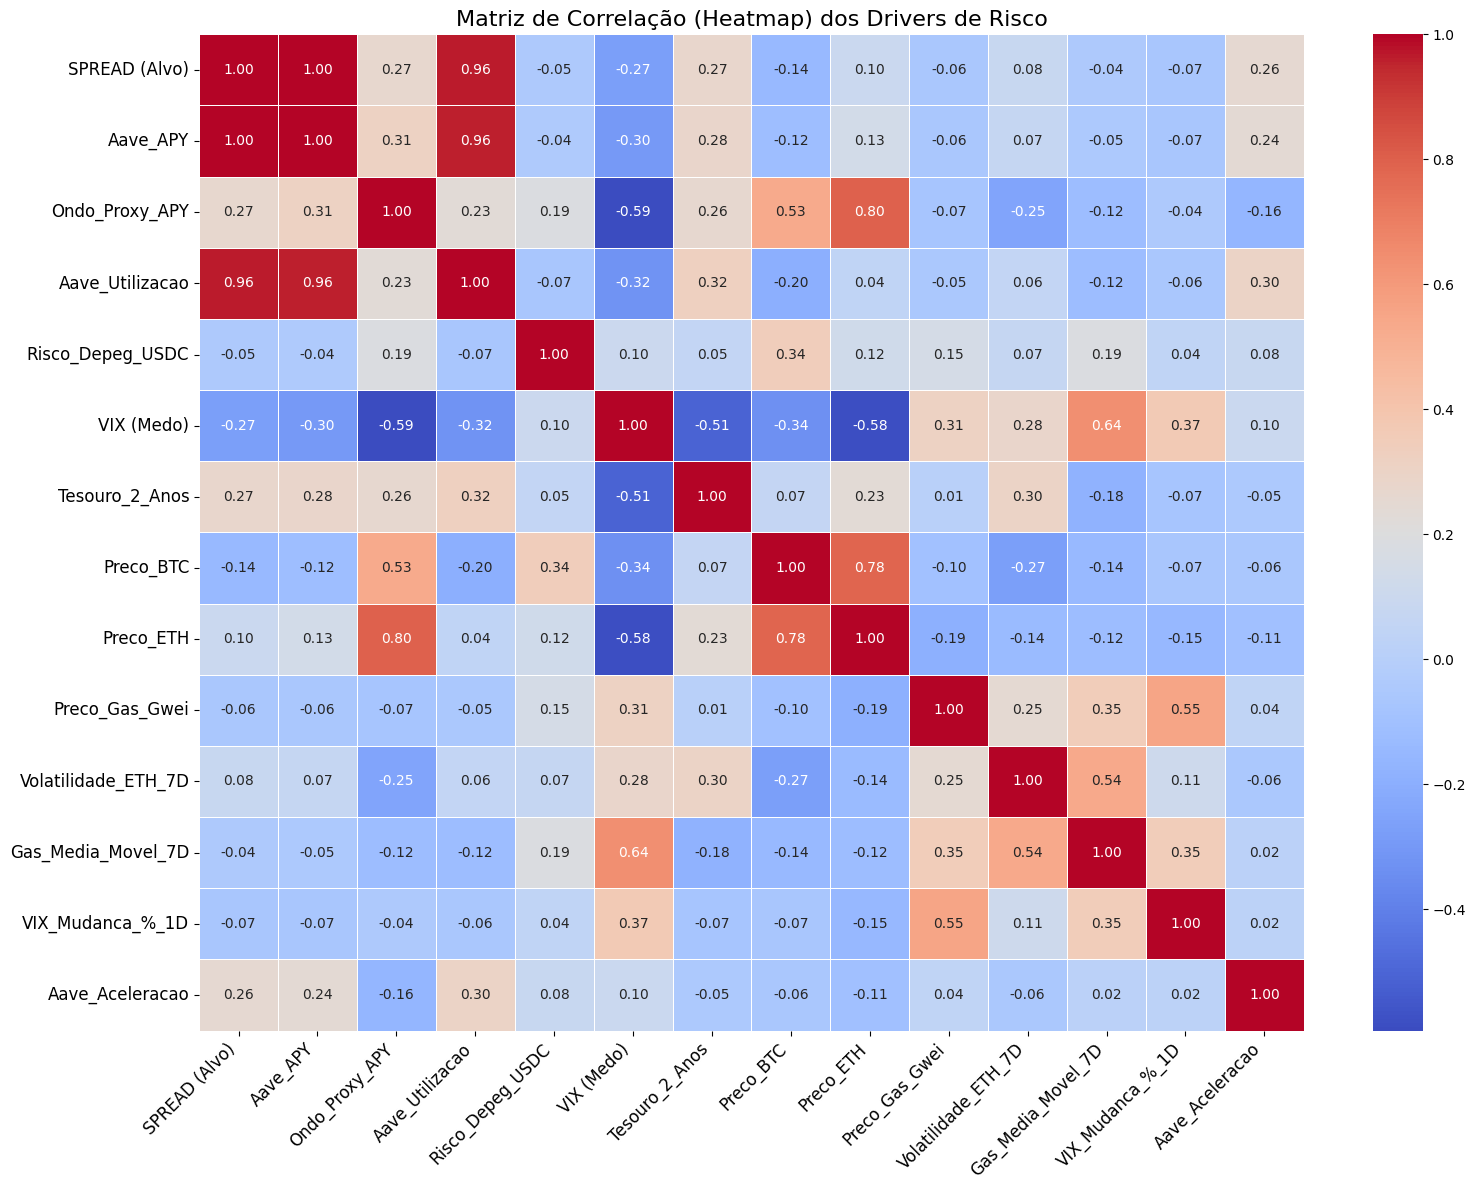

In [5]:

# --- 4. Gerar "A Matriz de Correlação (Heatmap)" ---

# Selecionar apenas as colunas-chave para o heatmap
# Vamos renomear as colunas para o gráfico ficar mais limpo e legível
# (O roteiro enfatiza 'storytelling' e 'show', então a legibilidade é crucial)
columns_to_plot = {
    'Y_Target_Spread': 'SPREAD (Alvo)',
    'Y1_Aave_APY': 'Aave_APY',
    'Y2_Ondo_Proxy_APY': 'Ondo_Proxy_APY',
    'X_Aave_Utilization': 'Aave_Utilizacao',
    'X_USDC_Depeg_Risk': 'Risco_Depeg_USDC',
    'X_VIX': 'VIX (Medo)',
    'X_DGS2': 'Tesouro_2_Anos',
    'X_BTC_Price': 'Preco_BTC',
    'X_ETH_Price': 'Preco_ETH',
    'X_Gas_Price_Gwei': 'Preco_Gas_Gwei',
    'X_ETH_Vol_7D': 'Volatilidade_ETH_7D',
    'X_Gas_MA_7D': 'Gas_Media_Movel_7D',
    'X_VIX_Pct_Change_1D': 'VIX_Mudanca_%_1D',
    'X_Aave_Util_Accel_1D': 'Aave_Aceleracao'
}

# Criar um novo DataFrame apenas com as colunas que queremos e renomeá-las
df_heatmap = df[columns_to_plot.keys()].rename(columns=columns_to_plot)

# Calcular a matriz de correlação
correlation_matrix = df_heatmap.corr()

# Plotar o heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Adicionar os números (anotações)
    cmap='coolwarm',     # Usar um mapa de cores divergente (vermelho-azul)
    fmt='.2f',           # Formatar os números para 2 casas decimais
    linewidths=.5,
    annot_kws={"size": 10} # Ajustar o tamanho da fonte
)
plt.title('Matriz de Correlação (Heatmap) dos Drivers de Risco', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()

# Plotar o gráfico
plt.plot()

In [6]:
# --- 5. Validar Hipóteses (Conforme Roteiro) ---
# Imprimir a correlação de todas as features com a variável-alvo
print("--- Validação de Hipóteses: Correlação com SPREAD (Alvo) ---")
correlation_with_target = correlation_matrix['SPREAD (Alvo)'].sort_values(ascending=False)
print(correlation_with_target)

--- Validação de Hipóteses: Correlação com SPREAD (Alvo) ---
SPREAD (Alvo)          1.000000
Aave_APY               0.998888
Aave_Utilizacao        0.964661
Tesouro_2_Anos         0.272975
Ondo_Proxy_APY         0.269026
Aave_Aceleracao        0.255318
Preco_ETH              0.096820
Volatilidade_ETH_7D    0.084150
Gas_Media_Movel_7D    -0.043332
Risco_Depeg_USDC      -0.046296
Preco_Gas_Gwei        -0.060964
VIX_Mudanca_%_1D      -0.068957
Preco_BTC             -0.144014
VIX (Medo)            -0.273250
Name: SPREAD (Alvo), dtype: float64


## Separando Features e Target

In [7]:
feature_columns = [col for col in df.columns if col.startswith('X_') or col == 'X_Spread_Lag1']

X = df[feature_columns]
Y = df['Y_Target_Spread']


# NUNCA usar shuffle=True em séries temporais
split_point = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
Y_train, Y_test = Y.iloc[:split_point], Y.iloc[split_point:]

print(f"--- Divisão dos Dados (Time Series Split) ---")
print(f"Total de amostras: {len(df)}")
print(f"Amostras de Treino: {len(Y_train)} (80%)")
print(f"Amostras de Teste:  {len(Y_test)} (20%)")

--- Divisão dos Dados (Time Series Split) ---
Total de amostras: 78
Amostras de Treino: 62 (80%)
Amostras de Teste:  16 (20%)


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

In [9]:
results = {}

# --- 4. Modelo 1: Baseline (O "Ingênuo") ---
# A previsão de "hoje" é o valor de "ontem".
y_pred_baseline = Y_test.shift(1)
# O primeiro valor do teste não tem "ontem", então usamos o último valor do treino.
y_pred_baseline.iloc[0] = Y_train.iloc[-1]

# Calcular Erros
mae_baseline = mean_absolute_error(Y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(Y_test, y_pred_baseline))
results['Baseline'] = {'MAE': mae_baseline, 'RMSE': rmse_baseline}


In [10]:
# --- 5. Modelo 2: Regressão Linear (O "Explicador") ---
model_lr = LinearRegression()
model_lr.fit(X_train, Y_train)
y_pred_lr = model_lr.predict(X_test)

# Calcular Erros
mae_lr = mean_absolute_error(Y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(Y_test, y_pred_lr))
results['Linear Regression'] = {'MAE': mae_lr, 'RMSE': rmse_lr}


In [11]:

# --- 6. Modelo 3: XGBoost (O "Trator") ---
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
model_xgb.fit(X_train, Y_train)
y_pred_xgb = model_xgb.predict(X_test)

# Calcular Erros
mae_xgb = mean_absolute_error(Y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(Y_test, y_pred_xgb))
results['XGBoost'] = {'MAE': mae_xgb, 'RMSE': rmse_xgb}


In [15]:

# --- 7. Comparar Resultados ---
print("--- Comparação de Performance dos Modelos (Erro) ---")
print("(Quanto menor o erro, melhor o modelo)\n")

df_results = pd.DataFrame(results).T
df_results['Performance (vs Baseline)'] = ((df_results['RMSE'] / rmse_baseline) - 1) * 100
print(df_results.to_markdown(floatfmt=".6f"))
print("\n")

# --- 8. Extrair Coeficientes da Regressão Linear ---
print("--- Coeficientes do Modelo 2 (Regressão Linear) ---")
print("O 'Explicador': O quanto o Spread (Y) muda para cada 1 unidade de X\n")
# Criar um DataFrame para os coeficientes
coefs = pd.DataFrame(
    model_lr.coef_,
    index=feature_columns,
    columns=['Coeficiente']
)
# Ordenar por valor absoluto para ver o que tem mais impacto
coefs['Impacto (Abs)'] = coefs['Coeficiente'].abs()
print(coefs.sort_values(by='Impacto (Abs)', ascending=False).to_markdown(floatfmt=".6f"))

print("\n\n--- Novos Resultados com AR(1) ---")
print("LinearRegression | RMSE:", np.sqrt(mean_squared_error(Y_test, model_lr.predict(X_test))))
print("XGBoost          | RMSE:", np.sqrt(mean_squared_error(Y_test, model_xgb.predict(X_test))))

--- Comparação de Performance dos Modelos (Erro) ---
(Quanto menor o erro, melhor o modelo)

|                   |      MAE |     RMSE |   Performance (vs Baseline) |
|:------------------|---------:|---------:|----------------------------:|
| Baseline          | 0.200278 | 0.358382 |                    0.000000 |
| Linear Regression | 0.198806 | 0.237714 |                  -33.670153 |
| XGBoost           | 0.315723 | 0.345210 |                   -3.675451 |


--- Coeficientes do Modelo 2 (Regressão Linear) ---
O 'Explicador': O quanto o Spread (Y) muda para cada 1 unidade de X

|                      |   Coeficiente |   Impacto (Abs) |
|:---------------------|--------------:|----------------:|
| X_USDC_Depeg_Risk    |    -13.326639 |       13.326639 |
| X_Aave_Utilization   |      5.203714 |        5.203714 |
| X_Aave_Util_Accel_1D |      4.889817 |        4.889817 |
| X_Spread_Lag1        |      0.495316 |        0.495316 |
| X_VIX_Pct_Change_1D  |     -0.056075 |        0.056075 |
|

## Summarizing

In [ ]:
import shap
import matplotlib.pyplot as plt

# --- FASE 5: O "SHOW" (SHAP) ---

# 1. Criar o Explicador
# (Assumindo que seu modelo treinado se chama 'model_xgb')
explainer = shap.TreeExplainer(model_xgb)

# 2. Calcular os valores SHAP
# (Assumindo que seus dados de teste se chamam 'X_test')
shap_values = explainer(X_test)

print("Valores SHAP calculados. Gerando o gráfico...")

# 3. Gerar o "Gráfico Vencedor"
# O SHAP Summary Plot
# Ele nos dá o ranking de features E a direção do impacto
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)

# Ajustes finos para salvar
plt.title("O 'Grand Finale': SHAP Summary Plot", fontsize=16)
plt.tight_layout()
plt.plot()